# GAM Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.gam import GAMFull, GAMAggregated, GAMMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [6]:
df_fs, fs_cols = make_fourier_series_df(df, 'week', 52, order=2)

In [7]:
df_fs.head()

,week,claims,trend.unemploy,trend.filling,trend.job,fs_cos1,fs_sin1,fs_cos2,fs_sin2
0,2010-01-03,13.38660,0.16888,-0.32831,0.11303,0.12054,-0.99271,-0.23932,0.97094
1,2010-01-10,13.62422,0.16888,-0.20470,0.16433,-0.66312,-0.74851,0.99271,0.12054
2,2010-01-17,13.39874,0.18514,-0.30233,0.11303,-1.00000,-0.00000,0.00000,-1.00000
3,2010-01-24,13.13755,0.15235,-0.20470,0.10245,-0.66312,0.74851,-0.99271,0.12054
4,2010-01-31,13.19676,0.08335,-0.25232,0.07002,0.12054,0.99271,0.23932,0.97094


### Train / Test Split

In [8]:
test_size=52
train_df=df_fs[:-test_size]
test_df=df_fs[-test_size:]

## VI Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [9]:
gam_vi = GAMFull(
    response_col='claims',
    date_col='week',
    regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] * 4 + ['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 7,
    regressor_knot_scale=[1] * 7,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_idx=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [10]:
%%time
gam_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1.7656e+05, scale = 0.11871
step  100 loss = 15879, scale = 0.75696
step  200 loss = -72.219, scale = 0.32786
step  300 loss = -89.961, scale = 0.40434
step  400 loss = -95.979, scale = 0.40221
step  500 loss = -96.346, scale = 0.41218
step  600 loss = -95.918, scale = 0.40126
step  700 loss = -98.017, scale = 0.40691
step  800 loss = -97.836, scale = 0.39383
step  900 loss = -98.486, scale = 0.3918
CPU times: user 2min 53s, sys: 4.44 s, total: 2min 57s
Wall time: 16.6 s


In [11]:
# data_input = gam_vi._get_model_data_input()
# data_input

In [12]:
# gam_vi._get_model_param_names()

In [13]:
predicted_df = gam_vi.predict(df=test_df)
predicted_df.head()

,week,prediction_lower,prediction,prediction_upper
0,2017-07-02,12.17184,12.39911,12.64265
1,2017-07-09,12.19590,12.44682,12.69678
2,2017-07-16,12.08701,12.33955,12.60354
3,2017-07-23,11.97921,12.23419,12.49864
4,2017-07-30,12.03098,12.28411,12.52955


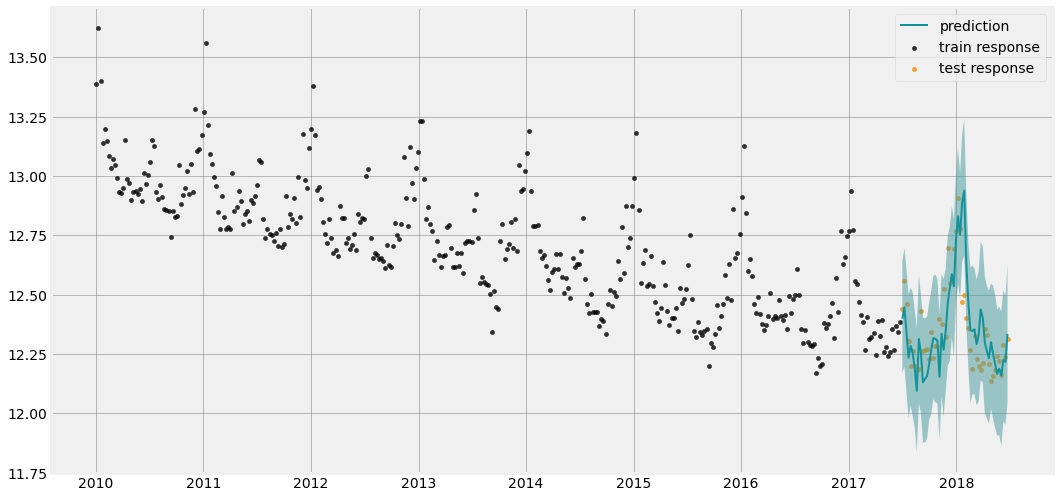

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [15]:
coef_df = gam_vi.get_regression_coefs()
coef_df.head()

,week,fs_cos1,fs_sin1,fs_cos2,fs_sin2,trend.unemploy,trend.filling,trend.job
0,2010-01-03,-0.07135,-0.01668,0.04154,0.04273,0.35486,0.99109,0.11727
1,2010-01-10,-0.07071,-0.01611,0.04083,0.04214,0.35884,0.98526,0.11697
2,2010-01-17,-0.07007,-0.01553,0.04012,0.04156,0.36287,0.97937,0.11667
3,2010-01-24,-0.06942,-0.01495,0.03940,0.04097,0.36697,0.97342,0.11637
4,2010-01-31,-0.06877,-0.01436,0.03867,0.04037,0.37111,0.96741,0.11606


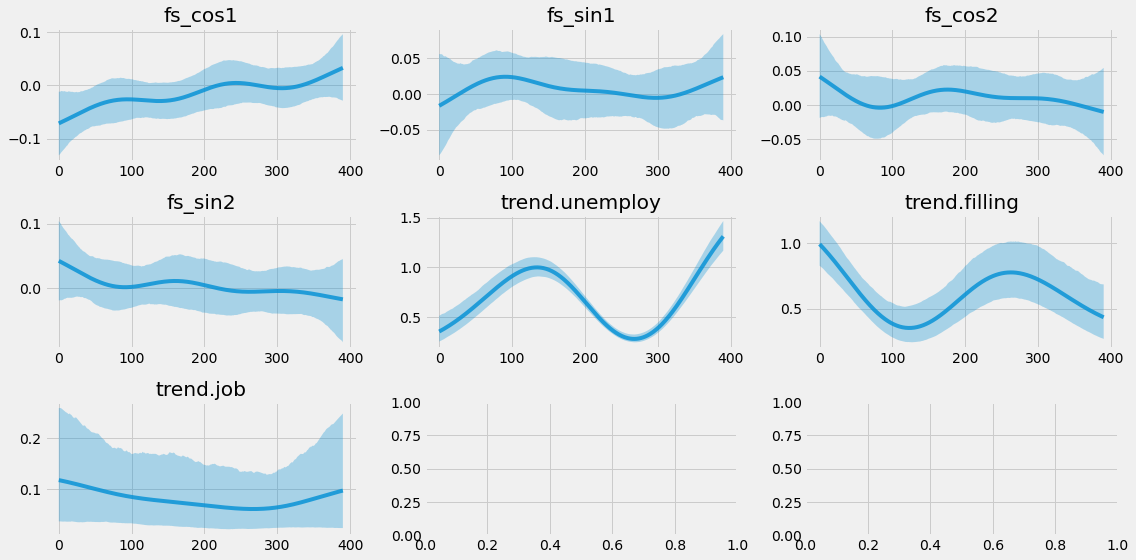

In [26]:
_ = gam_vi.plot_regression_coefs(ncol=3, figsize=(16, 8), include_ci=True)

## VI Fit and Predict - Aggregated

In [19]:
gam_vi_agg = GAMAggregated(
    response_col='claims',
    date_col='week',
    regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] * 4 + ['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 7,
    regressor_knot_scale=[1] * 7,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_idx=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [20]:
%%time
gam_vi_agg.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1.7656e+05, scale = 0.11871
step  100 loss = 15879, scale = 0.75696
step  200 loss = -72.219, scale = 0.32786
step  300 loss = -89.961, scale = 0.40434
step  400 loss = -95.979, scale = 0.40221
step  500 loss = -96.346, scale = 0.41218
step  600 loss = -95.918, scale = 0.40126
step  700 loss = -98.017, scale = 0.40691
step  800 loss = -97.836, scale = 0.39383
step  900 loss = -98.486, scale = 0.3918
CPU times: user 2min 51s, sys: 3.66 s, total: 2min 55s
Wall time: 16.3 s


In [21]:
predicted_df = gam_vi_agg.predict(df=test_df)
predicted_df.head()

,week,prediction
0,2017-07-02,12.39975
1,2017-07-09,12.44439
2,2017-07-16,12.33330
3,2017-07-23,12.23887
4,2017-07-30,12.27098


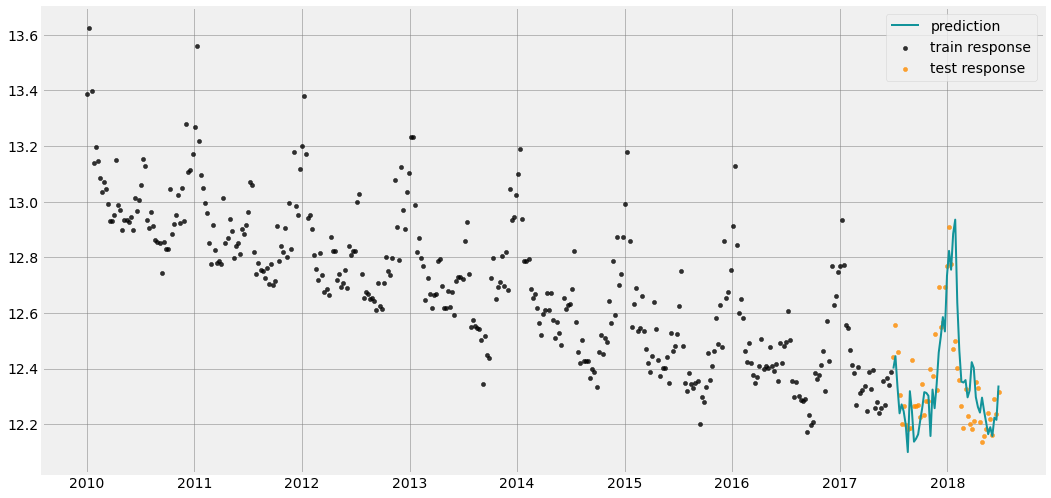

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [23]:
coef_df = gam_vi_agg.get_regression_coefs()
coef_df.head()

,week,fs_cos1,fs_sin1,fs_cos2,fs_sin2,trend.unemploy,trend.filling,trend.job
0,2010-01-03,-0.07139,-0.01681,0.04113,0.04375,0.33542,0.98615,0.09531
1,2010-01-10,-0.07086,-0.01645,0.04049,0.04323,0.33982,0.98002,0.09494
2,2010-01-17,-0.07024,-0.01600,0.03987,0.04244,0.34428,0.97419,0.09478
3,2010-01-24,-0.06963,-0.01549,0.03940,0.04183,0.34899,0.96822,0.09477
4,2010-01-31,-0.06901,-0.01474,0.03868,0.04108,0.35348,0.96186,0.09472


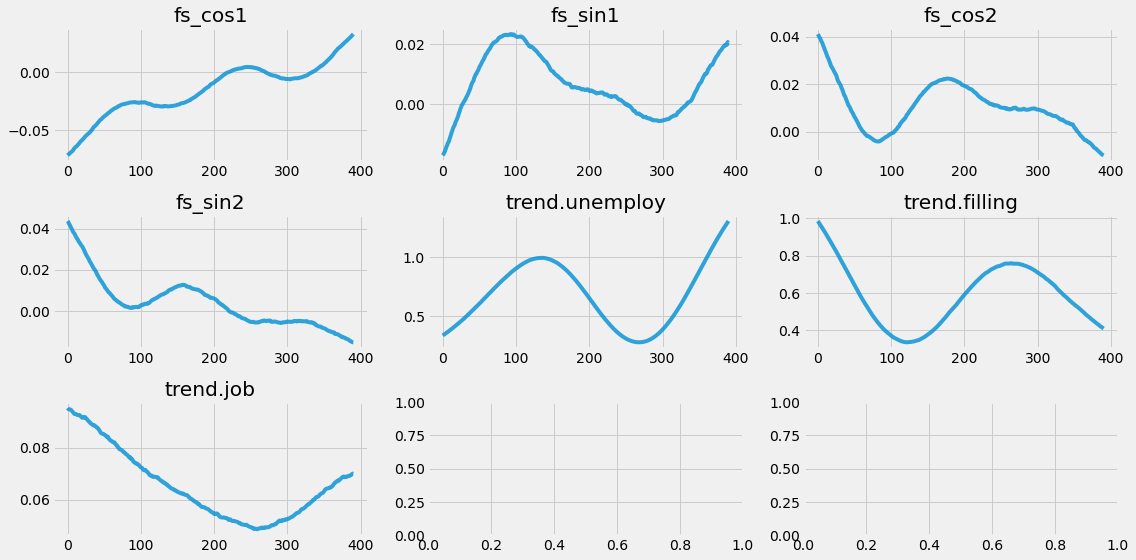

In [25]:
_ = gam_vi_agg.plot_regression_coefs(ncol=3, figsize=(16, 8))

## VI Fit and Predict - Aggregated

In [27]:
gam_map = GAMMAP(
    response_col='claims',
    date_col='week',
    regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] * 4 + ['+'] *3,
    
    level_knot_scale = 10,
    regressor_knot_loc=[0] * 7,
    regressor_knot_scale=[1] * 7,
    positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05,
    rho_coefficients=0.15,
    
    insert_prior_idx=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    estimator_type=PyroEstimatorMAP,
)

In [28]:
%%time
gam_map.fit(df=train_df)

step    0 loss = 25883
step  100 loss = 1091.7
step  200 loss = -134.61
step  300 loss = -164.27
step  400 loss = -164.25
step  500 loss = -164.21
step  600 loss = -164.18
step  700 loss = -164.17
step  800 loss = -164.16
step  900 loss = -164.16
CPU times: user 20.7 s, sys: 147 ms, total: 20.9 s
Wall time: 3.51 s


In [29]:
predicted_df = gam_map.predict(df=test_df)
predicted_df.head()

,week,prediction
0,2017-07-02,12.39207
1,2017-07-09,12.40283
2,2017-07-16,12.37462
3,2017-07-23,12.28238
4,2017-07-30,12.25035


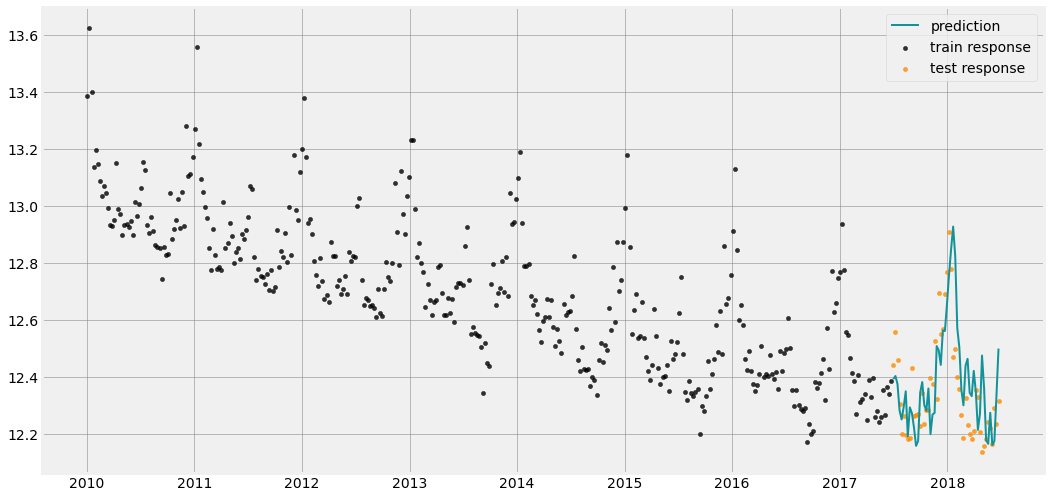

In [30]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [31]:
coef_df = gam_map.get_regression_coefs()
coef_df.head()

,week,fs_cos1,fs_sin1,fs_cos2,fs_sin2,trend.unemploy,trend.filling,trend.job
0,2010-01-03,-0.04398,-0.04226,0.03638,0.00571,0.32852,0.29702,0.00000
1,2010-01-10,-0.04387,-0.04098,0.03540,0.00586,0.33423,0.29963,0.00000
2,2010-01-17,-0.04376,-0.03969,0.03442,0.00601,0.34000,0.30225,0.00000
3,2010-01-24,-0.04365,-0.03839,0.03342,0.00617,0.34584,0.30489,0.00000
4,2010-01-31,-0.04353,-0.03708,0.03242,0.00633,0.35175,0.30754,0.00000


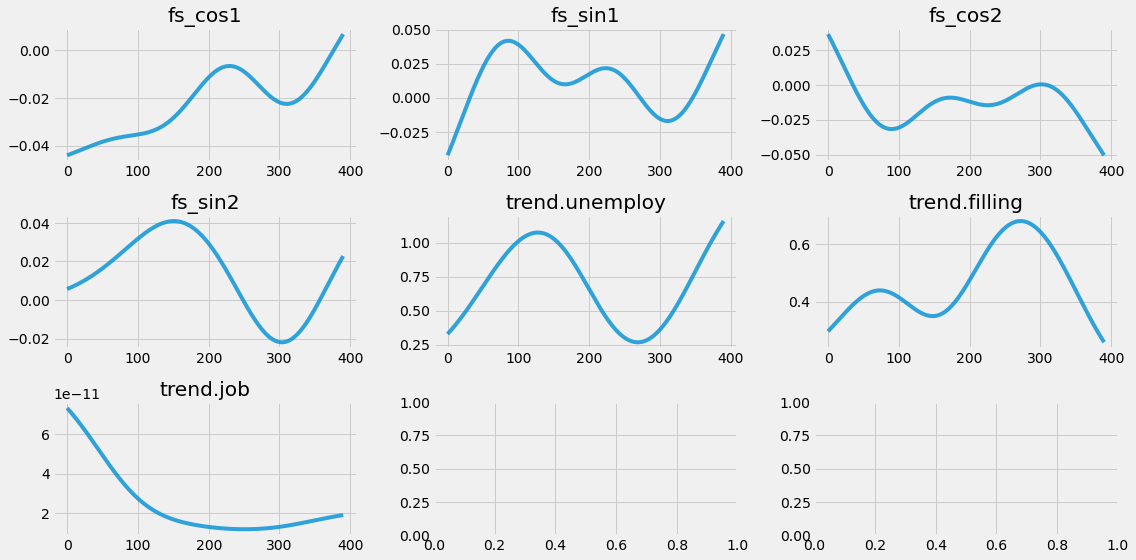

In [32]:
_ = gam_map.plot_regression_coefs(ncol=3, figsize=(16, 8))